# -1) Imports

In [1]:
import pandas as pd

from sklearn                  import datasets

from pyspark.sql              import Row
from pyspark.sql.types        import Row

from pyspark.ml               import Pipeline

from pyspark.ml.feature       import VectorAssembler

from pyspark.ml.clustering    import KMeans
from pyspark.ml.clustering    import KMeansModel

from pyspark.mllib.linalg     import Vectors
from pyspark.mllib.linalg     import SparseVector

from pyspark.mllib.regression import LabeledPoint

# 0) Spark 2.0 

In [244]:
spark = SparkSession\
        .builder\
        .appName("Boston")\
        .getOrCreate()

# 1) Imports de données : scikit learn-> pandas

In [2]:
#scikit-learn et pandas
boston        = datasets.load_boston()
data          = boston['data']
features      = boston['feature_names']
Y             = boston['target']
pd_df         = pd.DataFrame(data)
pd_df.columns = features
pd_df['Y']    = Y

In [3]:
print boston["DESCR"]

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

# 1.1) Création d'un ensemble d'apprentissage, et de test (en pandas)

In [247]:
from sklearn.cross_validation import train_test_split

In [248]:
train, test = train_test_split(pd_df)

In [249]:
train.shape

(379, 14)

In [250]:
test.shape

(127, 14)

# 2) Pandas -> Spark (pour les deux jeux : test + train)

In [251]:
#spark_df est une matrice d'objet 'ROW'
spark_train = spark.createDataFrame(train)
spark_test  = spark.createDataFrame(test)

In [252]:
spark_train.take(3)

[Row(CRIM=0.09512, ZN=0.0, INDUS=12.83, CHAS=0.0, NOX=0.437, RM=6.286, AGE=45.0, DIS=4.5026, RAD=5.0, TAX=398.0, PTRATIO=18.7, B=383.23, LSTAT=8.94, Y=21.4),
 Row(CRIM=0.22876, ZN=0.0, INDUS=8.56, CHAS=0.0, NOX=0.52, RM=6.405, AGE=85.4, DIS=2.7147, RAD=5.0, TAX=384.0, PTRATIO=20.9, B=70.8, LSTAT=10.63, Y=18.6),
 Row(CRIM=0.44178, ZN=0.0, INDUS=6.2, CHAS=0.0, NOX=0.504, RM=6.552, AGE=21.4, DIS=3.3751, RAD=8.0, TAX=307.0, PTRATIO=17.4, B=380.34, LSTAT=3.76, Y=31.5)]

In [253]:
spark_test.take(3)

[Row(CRIM=0.05789, ZN=12.5, INDUS=6.07, CHAS=0.0, NOX=0.409, RM=5.878, AGE=21.4, DIS=6.498, RAD=4.0, TAX=345.0, PTRATIO=18.9, B=396.21, LSTAT=8.1, Y=22.0),
 Row(CRIM=4.22239, ZN=0.0, INDUS=18.1, CHAS=1.0, NOX=0.77, RM=5.803, AGE=89.0, DIS=1.9047, RAD=24.0, TAX=666.0, PTRATIO=20.2, B=353.04, LSTAT=14.64, Y=16.8),
 Row(CRIM=0.11132, ZN=0.0, INDUS=27.74, CHAS=0.0, NOX=0.609, RM=5.983, AGE=83.5, DIS=2.1099, RAD=4.0, TAX=711.0, PTRATIO=20.1, B=396.9, LSTAT=13.35, Y=20.1)]

# 3) Création d'un vecteur de features

In [254]:
# parametres
col_label        = "Y"
ignore           = [col_label]
inputCols        = [x for x in spark_train.columns if x not in ignore]
outputCol        = 'features'
FeaturesCol      = outputCol
predictionCol    = "prediction"

# 3.1) Créer une colonne de vecteurs à partir des objets 'Row‘
# transformer
assembler        = VectorAssembler(inputCols = inputCols,
                                   outputCol = outputCol)
# 4.1) trasnformation (via le transformer)
transformed_train = assembler.transform(spark_train)
transformed_test  = assembler.transform(spark_test)

In [255]:
transformed_train.take(1)

[Row(CRIM=0.09512, ZN=0.0, INDUS=12.83, CHAS=0.0, NOX=0.437, RM=6.286, AGE=45.0, DIS=4.5026, RAD=5.0, TAX=398.0, PTRATIO=18.7, B=383.23, LSTAT=8.94, Y=21.4, features=DenseVector([0.0951, 0.0, 12.83, 0.0, 0.437, 6.286, 45.0, 4.5026, 5.0, 398.0, 18.7, 383.23, 8.94]))]

# 4) Modélisation

In [256]:
from pyspark.ml.regression import DecisionTreeRegressor


In [257]:
arbreDeDecision = DecisionTreeRegressor(featuresCol=outputCol, labelCol=col_label)


# 4.1) on modélise sur le jeu d'apprentissage

In [258]:
arbreDeDecision = arbreDeDecision.fit(transformed_train)

# 4.2) on peut prédire les deux jeux

### 4.2.1) prédiction sur le jeu d'apprentissage

In [259]:
predicted_train   = arbreDeDecision.transform(transformed_train)

In [260]:
predicted_train.select([col_label, predictionCol]).take(3)

[Row(Y=21.4, prediction=24.75471698113208),
 Row(Y=18.6, prediction=16.566666666666666),
 Row(Y=31.5, prediction=27.564705882352943)]

### 4.2.2) prédiction sur le jeux de test

In [261]:
predicted_test = arbreDeDecision.transform(transformed_test)
    

In [ ]:
predicted_test.select([col_label, predictionCol]).take(3)


## 4.3) evaluation de la modélisation

In [263]:
from pyspark.ml.evaluation import RegressionEvaluator

In [264]:
metrics    = ["rmse", "r2", "mae", "mse"]
for metric in  metrics:
    evaluation = RegressionEvaluator(predictionCol=predictionCol, labelCol=col_label, metricName=metric)
    print "-"*5
    print "metric : ", metric
    print "train  : ", "{:0.2}".format(evaluation.evaluate(predicted_train))
    print "test   : ", "{:0.2}".format(evaluation.evaluate(predicted_test))

-----
metric :  rmse
train  :  2.7
test   :  3.8
-----
metric :  r2
train  :  0.92
test   :  0.81
-----
metric :  mae
train  :  2.0
test   :  2.5
-----
metric :  mse
train  :  7.3
test   :  1.4e+01


# 4.4) effet de la variation du nombre d'arbres

In [265]:
import time

In [266]:
performances = {}
tps_calcul   = {}
for maxDepth in range (30):
    debut = time.time()
    print "maxDepth", maxDepth, "\t",
    arbreDeDecision = DecisionTreeRegressor(featuresCol=outputCol, labelCol=col_label, maxDepth=maxDepth)
    arbreDeDecision = arbreDeDecision.fit(transformed_train)
    predicted_test = arbreDeDecision.transform(transformed_test)
    metrics    = [ "r2"]#["rmse", "r2", "mae", "mse"]
    for metric in  metrics:
        evaluation = RegressionEvaluator(predictionCol=predictionCol, labelCol=col_label, metricName=metric)
        qualite = evaluation.evaluate(predicted_test)
        print "{:7s} {:0.2}".format(metric, qualite)
        performances[maxDepth]=qualite
    duree = time.time()-debut
    tps_calcul[maxDepth] = duree


maxDepth 0 	r2      -0.00083
maxDepth 1 	r2      0.42
maxDepth 2 	r2      0.76
maxDepth 3 	r2      0.81
maxDepth 4 	r2      0.82
maxDepth 5 	r2      0.81
maxDepth 6 	r2      0.83
maxDepth 7 	r2      0.81
maxDepth 8 	r2      0.81
maxDepth 9 	r2      0.8
maxDepth 10 	r2      0.8
maxDepth 11 	r2      0.8
maxDepth 12 	r2      0.8
maxDepth 13 	r2      0.8
maxDepth 14 	r2      0.79
maxDepth 15 	r2      0.8
maxDepth 16 	r2      0.8
maxDepth 17 	r2      0.8
maxDepth 18 	r2      0.8
maxDepth 19 	r2      0.8
maxDepth 20 	r2      0.8
maxDepth 21 	r2      0.8
maxDepth 22 	r2      0.8
maxDepth 23 	r2      0.8
maxDepth 24 	r2      0.8
maxDepth 25 	r2      0.8
maxDepth 26 	r2      0.8
maxDepth 27 	r2      0.8
maxDepth 28 	r2      0.8
maxDepth 29 	r2      0.8


# 4.5) Passage dans python / pandas pour afficher les performances

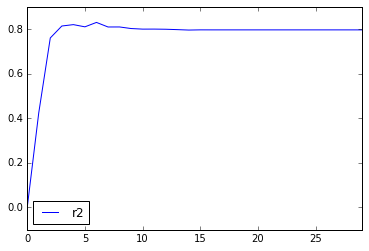

In [267]:
%matplotlib inline
tps_calcul_df           = pd.DataFrame.from_dict(tps_calcul, 'index')
tps_calcul_df.columns   = ["sec"]
performances_df         = pd.DataFrame.from_dict(performances, 'index')
performances_df.columns = [metric]

performances_df.plot()


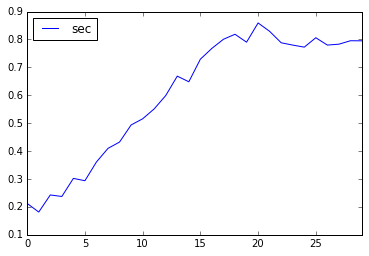

In [268]:
tps_calcul_df.plot()

In [269]:
infos = pd.concat([performances_df,tps_calcul_df], ignore_index=True, axis=1)

In [270]:
infos.columns=[metric, "sec"]

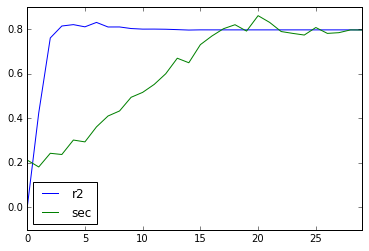

In [271]:
try: infos = infos.drop("performance", axis=1)
except:pass
infos.plot()

In [272]:
infos["performance"] = infos[metric]/infos["sec"]

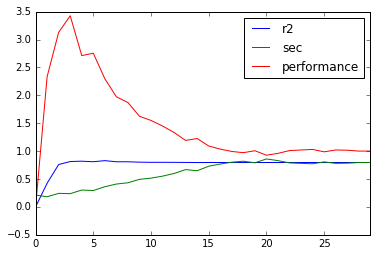

In [273]:
infos.plot()

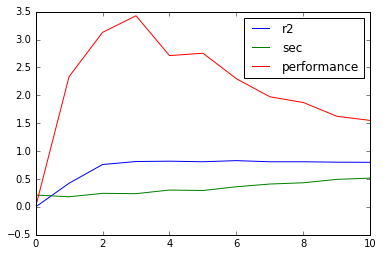

In [274]:
infos.plot(xlim=[0,10])

# 7) organiser l'algorithme (step 4) dans un Pipeline

In [306]:
best_depth      = 6
arbreDeDecision = DecisionTreeRegressor(featuresCol=outputCol, labelCol=col_label, maxDepth=best_depth)
stages          = [assembler, arbreDeDecision]
pipeline        = Pipeline(stages=stages)

# 7.1) Fitter le pipeline / obetenir un modèle 

In [307]:
pipelineModel = pipeline.fit(spark_train)

# 7.2) Appliquer le pipeline sur la spark dataframe

In [308]:
predicted_test = pipelineModel.transform(spark_test)

In [309]:
evaluation.evaluate(predicted_test)

0.8291257712874524